In [1]:
import rasterio
from rasterio.windows import Window
import numpy as np

def split_raster_with_buffer(input_raster, output_dir, tile_size=1000, buffer_size=250):
    with rasterio.open(input_raster) as src:
        width = src.width
        height = src.height
        transform = src.transform
        meta = src.meta.copy()

        # Calculate the number of tiles in x and y direction
        num_tiles_x = int(np.ceil(width / tile_size))
        num_tiles_y = int(np.ceil(height / tile_size))

        for i in range(num_tiles_x):
            for j in range(num_tiles_y):
                # Calculate window position with buffer
                x_off = max(i * tile_size - buffer_size, 0)
                y_off = max(j * tile_size - buffer_size, 0)
                x_end = min((i + 1) * tile_size + buffer_size, width)
                y_end = min((j + 1) * tile_size + buffer_size, height)

                window = Window(x_off, y_off, x_end - x_off, y_end - y_off)
                transform_window = rasterio.windows.transform(window, transform)

                meta.update({
                    "height": window.height,
                    "width": window.width,
                    "transform": transform_window
                })

                output_path = f"{output_dir}/tile_{i}_{j}.tif"
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(src.read(window=window))

# Example usage
input_raster = '/Users/lisawink/Documents/SVF/DSM1_25832_0_Building_Lod1OSM2.tif'
output_dir = '/Users/lisawink/Documents/SVF/'
split_raster_with_buffer(input_raster, output_dir)

In [45]:

def get_1000x1000_grid(input_raster, output_dir, tile_size=1000, buffer_size=250):
    # Open the input raster
    with rasterio.open(input_raster) as src:
        width = src.width
        height = src.height
        transform = src.transform
        meta = src.meta.copy()

        # Calculate the number of tiles in x and y direction
        num_tiles_x = int(np.ceil(width / tile_size))
        num_tiles_y = int(np.ceil(height / tile_size))

        for i in range(num_tiles_x):
            for j in range(num_tiles_y):
                # Calculate window position with buffer (we reverse the buffer)
                x_off = max(i * tile_size, 0)  # no buffer on the left side for final 1000m tile
                y_off = max(j * tile_size, 0)  # no buffer on the top side for final 1000m tile
                x_end = min((i + 1) * tile_size, width)  # no buffer on the right side for final 1000m tile
                y_end = min((j + 1) * tile_size, height)  # no buffer on the bottom side for final 1000m tile

                # Define the window for the 1000x1000 m grid (without buffer)
                window = Window(x_off, y_off, x_end - x_off, y_end - y_off)
                transform_window = rasterio.windows.transform(window, transform)

                # Update metadata for the 1000x1000 m grid
                meta.update({
                    "height": window.height,
                    "width": window.width,
                    "transform": transform_window
                })

                # Generate the output file path for the 1000x1000 m grid tiles
                output_path = f"{output_dir}/tile_{i}_{j}_1000m.tif"
                
                # Write the 1000x1000 m tile to disk
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(src.read(window=window))



In [47]:
input_raster = '/Users/lisawink/Documents/paper1/data/SVF/DSM1_25832_0_Building_Lod1OSM2.tif'
output_dir = '/Users/lisawink/Documents/paper1/data/SVF/'
get_1000x1000_grid(input_raster, output_dir)

In [3]:
with rasterio.open(input_raster) as src:
    width = src.width
    height = src.height
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 17400, 'height': 12000, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(1.0, 0.0, 402200.0,
       0.0, -1.0, 5323700.0)}


In [1]:
import os
from dotenv import load_dotenv

In [6]:
load_dotenv()
data_dir = os.getenv("DATA_PATH")
file_path = os.path.join(data_dir, "SVF/")


In [7]:
file_path

'/Users/lisawink/Documents/paper1/data/SVF/'

In [18]:
tiles = []

In [58]:
from rasterio import mask
from shapely.geometry import box

tiles_to_merge = []

for i in range(0,18):
    for j in range (0,12):
            tile = 'tile_'+str(i)+'_'+str(j)
            svf_tile = rasterio.open(file_path+tile+'/svf.tif')
            grid_ref = rasterio.open(file_path+tile+'_1000m.tif').bounds

            geom = box(*grid_ref)

            #clip svf tile to grid tile
            svf_tile_clip, svf_transform = mask.mask(svf_tile, [geom], crop=True)
            svf_meta = svf_tile.meta.copy()
            svf_meta.update({"height": svf_tile_clip.shape[1], "width": svf_tile_clip.shape[2], "transform": svf_transform})
            #svf_tile_clip = svf_tile_clip[0]
            #svf_tile_clip = svf_tile_clip.astype('float32')

            #write clipped svf tile to disk
            with rasterio.open(file_path+tile+'_1000m_svf.tif', 'w', **svf_meta) as dst:
                dst.write(svf_tile_clip)

            tiles_to_merge.append(file_path+tile+'_1000m_svf.tif')

In [59]:
from rasterio.merge import merge


src_files_to_mosaic = []
for tile in tiles_to_merge:
    src = rasterio.open(tile)
    src_files_to_mosaic.append(src)

# Merge the rasters, handling the overlaps
mosaic, out_transform = merge(src_files_to_mosaic)

height, width = mosaic.shape[1], mosaic.shape[2]

with rasterio.open('merged_raster_no_overlap.tif', 'w', 
                       driver='GTiff', 
                       count=1, 
                       dtype=mosaic.dtype, 
                       crs=src_files_to_mosaic[0].crs, 
                       transform=out_transform, 
                       width=width, 
                       height=height, 
                       nodata=np.nan) as dst:
        dst.write(mosaic[0], 1)

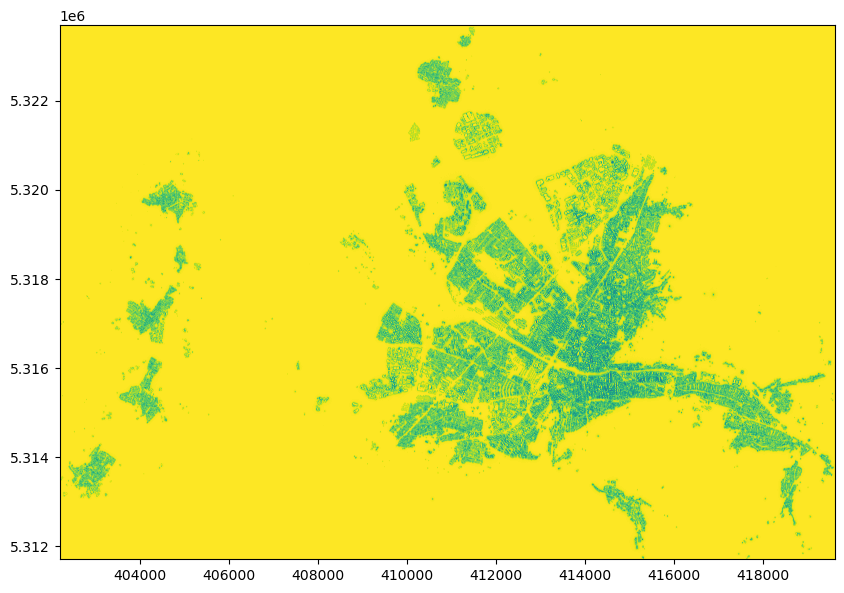

In [60]:
# plot mosaic
import matplotlib.pyplot as plt
from rasterio.plot import show

with rasterio.open('merged_raster_no_overlap.tif') as src:
    plt.figure(figsize=(10, 10))
    show(src)

In [12]:
import rasterio
import numpy as np
from rasterio.merge import merge

def merge_rasters_ignore_overlap(tiles):
    # Read all raster tiles into a list of datasets
    src_files_to_mosaic = []
    for tile in tiles:
        src = rasterio.open(tile)
        src_files_to_mosaic.append(src)

    # Merge the rasters, handling the overlaps
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Get the shape of the mosaic
    height, width = mosaic.shape[1], mosaic.shape[2]
    
    # Create a mask array to track where the data has been overwritten by multiple rasters
    overlap_mask = np.zeros((height, width), dtype=bool)

    # Loop over each tile and update the overlap mask
    for src in src_files_to_mosaic:
        data = src.read(1)  # Read the data for the current tile
        mask = data != src.nodata  # Create a mask for valid data (not NoData)
        
        # Mark overlaps as True where data exists in the current tile
        overlap_mask = np.logical_or(overlap_mask, mask)

    # Now replace all overlapping regions in the mosaic with np.nan
    mosaic = np.where(overlap_mask, mosaic, np.nan)

    # Save the merged result as a new raster
    with rasterio.open('merged_raster_no_overlap.tif', 'w', 
                       driver='GTiff', 
                       count=1, 
                       dtype=mosaic.dtype, 
                       crs=src_files_to_mosaic[0].crs, 
                       transform=out_transform, 
                       width=width, 
                       height=height, 
                       nodata=np.nan) as dst:
        dst.write(mosaic[0], 1)

    # Close all the opened rasters
    for src in src_files_to_mosaic:
        src.close()

